Toxic Comment Classification

Import modules

In [65]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import CategorizedPlaintextCorpusReader
import nltk

1. Data Download and Loading

1.1 Loading Data with pandas

In [80]:
def load_data(train_path, test_path):
    df_train = pd.read_csv(train_path)
    df_test  = pd.read_csv(test_path)

    label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    df_train['non_toxic'] = (df_train[label_cols].sum(axis=1) == 0).astype(int)

    return df_train, df_test

# Example usage
df_train, df_test = load_data(
    'Dataset/train.csv',
    'Dataset/test.csv'
)

1.2 Initial Inspection

Display dimensions:

In [67]:
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (159571, 9)
Test shape: (153164, 2)


Show first rows:

In [68]:
display(df_train.head())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


Null values by column in train:

In [69]:
print(df_train.isnull().sum())

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
non_toxic        0
dtype: int64


Label distribution in train:

In [70]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non_toxic']
print(df_train[label_cols].sum().sort_values(ascending=False))

non_toxic        143346
toxic             15294
obscene            8449
insult             7877
severe_toxic       1595
identity_hate      1405
threat              478
dtype: int64


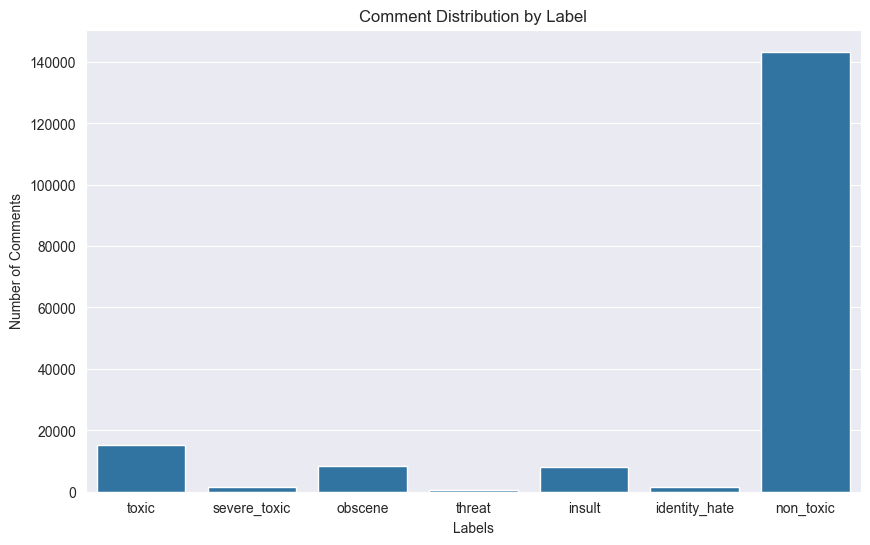

In [71]:
plt.figure(figsize=(10,6))
sns.barplot(x=df_train[label_cols].sum().index, y=df_train[label_cols].sum().values)
plt.title('Label distribution')
plt.title('Comment Distribution by Label')
plt.ylabel('Number of Comments')
plt.xlabel('Labels')
plt.show()

2. Exploratory Data Analysis (EDA)

2.1 Missing Values and Null Checks

In [72]:
df_train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
non_toxic        0
dtype: int64

2.2 Class Distribution

The dataset has six target columns: toxic, severe_toxic, obscene, threat, insult, identity_hate.

Display the count and proportion of each class:

In [73]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non_toxic']
class_counts = df_train[label_cols].sum().sort_values(ascending=False)
class_props = class_counts / len(df_train)
print(pd.concat([class_counts, class_props], axis=1, keys=['count','proportion']))

                count  proportion
non_toxic      143346    0.898321
toxic           15294    0.095844
obscene          8449    0.052948
insult           7877    0.049364
severe_toxic     1595    0.009996
identity_hate    1405    0.008805
threat            478    0.002996


2.3 Comment Length Analysis

Compute length of each comment (in characters and words):

In [74]:
df_train['char_count'] = df_train['comment_text'].apply(len)
df_train['word_count'] = df_train['comment_text'].apply(lambda x: len(x.split()))
display(df_train[['char_count','word_count']].describe())

,char_count,word_count
count,159571.000000,159571.000000
mean,396.593961,67.273527
std,594.387869,99.230702
min,6.000000,1.000000
25%,97.000000,17.000000
50%,207.000000,36.000000
75%,438.000000,75.000000
max,5000.000000,1411.000000


Plot histograms of comment lengths:

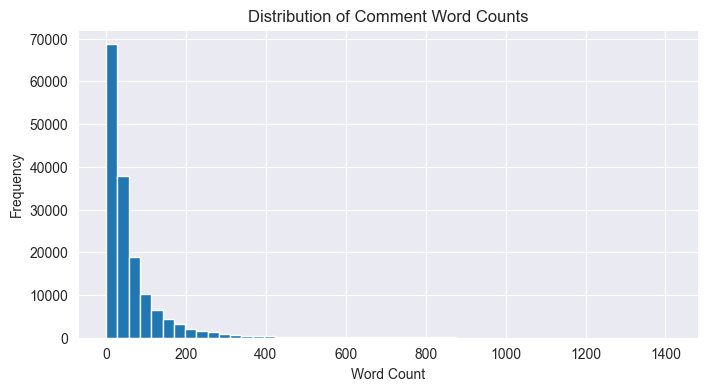

In [75]:
plt.figure(figsize=(8,4))
df_train['word_count'].hist(bins=50)
plt.title('Distribution of Comment Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

2.4 Sample Comments by Category

Show example comments for each label where the label is 1:

In [76]:
for col in label_cols:
    print(f"\nExamples of {col} comments:")
    examples = df_train[df_train[col]==1]['comment_text'].sample(2, random_state=42).tolist()
    for ex in examples:
        print("- ", ex)


Examples of toxic comments:
-  Hi! 

I wanna rape you!
-  Terrorize 
I will terrorise you for as long as you live - you are an arrogant, disgusting and rude excuse for a human being & you are going to die soon so I suggest you stop threatening people you bastard.

Examples of severe_toxic comments:
-  "

 WHAT  IN THE FUCK ARE YOU REFERRING TOO 

I HAVE NO IDEA WHAT THE PISS YOU'RE REFERRING TOO, OR WHY YOU BOTHERED TO WRITE ME.  LISTEN I'VE ADDED PLENTY TO THESE PAGE INCLUDING A ""SMASHING"" ARTICLE ON SMASHED GLADYS...BUT THAT REALLY ISNT ANY OF YOU BUSSINESS NOW IS IT.  IF SOMEBODY HAS A PROBLEM WITH ANYTHING THAT I WROTE THEM I ASSUME THEY CAN CONTACT ME THROUGH REGULAR MEANS WITHOUT YOU HAVING TO ""WIPE THEIR ASS"" FOR THEM.  IF I CAPITALIZE IT IS NOT MEANT NECCISARYLY AS AN INSULT, AND MOST PEOPLE I WRITE UNDERSTAND THAT.  IN THIS CASE IT IS BECAUSE MY CAPS BUTTON ISNT WORKING FOR SOME REASON.  SO HERES AN IDEA FOR YOU...DONT SHOVE YOUR NOSE IN MY BUSSINESS, I AM CLOSE FREINDS W

3. Create corpus

In [77]:
# Crear el directorio principal para almacenar el corpus
corpus_dir = 'corpus_by_label'
os.makedirs(corpus_dir, exist_ok=True)

# Guardar los comentarios en carpetas y archivos separados por etiqueta
for label in label_cols:
    comments = df_train[df_train[label] == 1]['comment_text'].dropna()

    # Crear una carpeta con el nombre de la etiqueta
    label_dir = os.path.join(corpus_dir, label)
    os.makedirs(label_dir, exist_ok=True)

    # Ruta del archivo dentro de la carpeta creada
    file_path = os.path.join(label_dir, f"{label}.txt")

    # Guardar todos los comentarios de la etiqueta en el archivo dentro de su carpeta
    with open(file_path, 'w', encoding='utf-8') as f:
        for comment in comments:
            f.write(comment.replace('\n', ' ') + '\n')

print(f"Corpus successfully loaded in: {corpus_dir}")

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non_toxic']
Corpus successfully loaded in: corpus_by_label


In [78]:
nltk.download('punkt')

# Load corpus
corpus = CategorizedPlaintextCorpusReader(
    corpus_dir,
    r'.*\.txt',
    cat_pattern=r"([^/.]+)/.*"
)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hugom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [79]:
print("File IDs:", corpus.fileids())
print("Categories:", corpus.categories())

File IDs: ['identity_hate/identity_hate.txt', 'insult/insult.txt', 'non_toxic/non_toxic.txt', 'obscene/obscene.txt', 'severe_toxic/severe_toxic.txt', 'threat/threat.txt', 'toxic/toxic.txt']
Categories: ['identity_hate', 'insult', 'non_toxic', 'obscene', 'severe_toxic', 'threat', 'toxic']


In [81]:
print("Primeras 10 palabras de 'toxic':")
print(corpus.words(categories='toxic')[:10])

Primeras 10 palabras de 'toxic':
['COCKSUCKER', 'BEFORE', 'YOU', 'PISS', 'AROUND', 'ON', 'MY', 'WORK', 'Hey', '...']
